# Wine Classification using K-Nearest Neighbors (KNN)

In this notebook, we will build a **K-Nearest Neighbors (KNN)** classifier to predict the type of wine based on chemical characteristics. 
<br>These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. 
<br>The analysis determined the quantities of 13 constituents found in each of the three types of wines. 
<br>Using this information, we try to predict from which cultivar the wine originates.

## Step 1: Data Loading and Inspection

We start by importing the packages that we will be using for our model and loading the wine dataset. 
<br>We use: 
    <br>`pandas` to analyze and prepare the data 
    <br>`numpy` to normalize the data (this will be explained later on) 
    <br>`scikit-learn` packages to apply the model and split the data into training and test data
    <br>`matplotlib/pyplot` and the confusion matrix from `scikit-learn` to visualize the data

In [51]:
# Importing relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Load the dataset
wine_df = pd.read_csv('wine.csv')

# Display basic information about the dataset
wine_df.info(), wine_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Wine                  178 non-null    int64  
 1   Alcohol               178 non-null    float64
 2   Malic.acid            178 non-null    float64
 3   Ash                   178 non-null    float64
 4   Acl                   178 non-null    float64
 5   Mg                    178 non-null    int64  
 6   Phenols               178 non-null    float64
 7   Flavanoids            178 non-null    float64
 8   Nonflavanoid.phenols  178 non-null    float64
 9   Proanth               178 non-null    float64
 10  Color.int             178 non-null    float64
 11  Hue                   178 non-null    float64
 12  OD                    178 non-null    float64
 13  Proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


(None,
    Wine  Alcohol  Malic.acid   Ash   Acl   Mg  Phenols  Flavanoids  \
 0     1    14.23        1.71  2.43  15.6  127     2.80        3.06   
 1     1    13.20        1.78  2.14  11.2  100     2.65        2.76   
 2     1    13.16        2.36  2.67  18.6  101     2.80        3.24   
 3     1    14.37        1.95  2.50  16.8  113     3.85        3.49   
 4     1    13.24        2.59  2.87  21.0  118     2.80        2.69   
 
    Nonflavanoid.phenols  Proanth  Color.int   Hue    OD  Proline  
 0                  0.28     2.29       5.64  1.04  3.92     1065  
 1                  0.26     1.28       4.38  1.05  3.40     1050  
 2                  0.30     2.81       5.68  1.03  3.17     1185  
 3                  0.24     2.18       7.80  0.86  3.45     1480  
 4                  0.39     1.82       4.32  1.04  2.93      735  )

Now that we have loaded the data and taken a closer look at how the dataset is built up, we plot the distribution of a couple of variables in a scatter matrix.

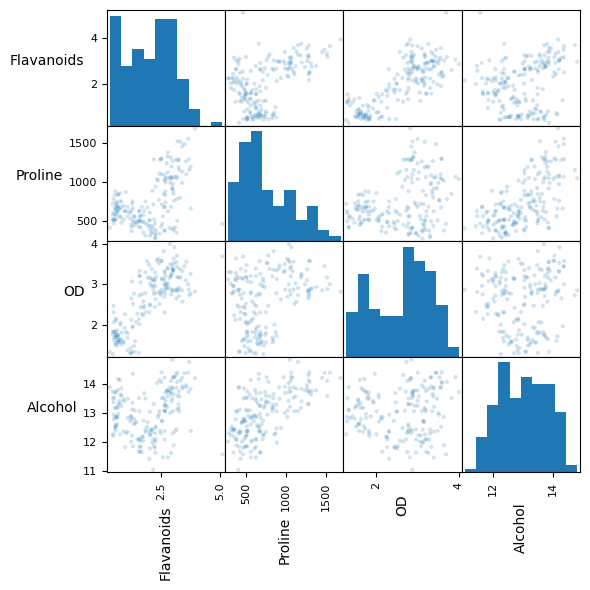

In [52]:

# Select the specified columns for the scatter matrix
selDF = wine_df[['Flavanoids', 'Proline', 'OD', 'Alcohol']]

# Plot the scatter matrix for these selected features
fig = pd.plotting.scatter_matrix(selDF, alpha=0.2, figsize=(6, 6), diagonal="hist")

# Rotate labels for better readability
for ax in fig.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha("right")

# Adjust layout and show the plot
plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

The chart shows that wines with higher levels of flavanoids also tend to have higher OD values, which might help in telling wine types apart. 
<br>Proline levels are mostly low but vary widely, giving extra information that could help classify different wines.
<br>
<br>Next, we take a closer look at the types of wine and how many there are of each in our dataset.

In [53]:
cntWine = wine_df["Wine"].value_counts() # Counts how many of each wine is in the dataset
propWine = wine_df["Wine"].value_counts(normalize=True) # Counts the proportion of each wine in percentages
cntWine

Wine
2    71
1    59
3    48
Name: count, dtype: int64

In [54]:
propWine

Wine
2    0.398876
1    0.331461
3    0.269663
Name: proportion, dtype: float64

## Step 2: Data Preparation 
There are a few steps that need to be taken to prepare the data so that it can be given to the model.
<br>
First, we turn "Wine" into categories so that it tells the model to treat it as different wine types instead of numbers, helping it classify wines correctly.

In [55]:

catType = pd.CategoricalDtype(categories=[1, 2, 3], ordered=False)
wine_df["Wine"] = wine_df["Wine"].astype(catType)
wine_df["Wine"]

0      1
1      1
2      1
3      1
4      1
      ..
173    3
174    3
175    3
176    3
177    3
Name: Wine, Length: 178, dtype: category
Categories (3, int64): [1, 2, 3]

The next step is normalizing the data. 
<br>We normalize data to ensure that all features (like chemical measurements) are on the same scale, so no single feature dominates just because it has larger numbers. 
<br>This is especially important for distance-based models like KNN, where features with bigger values could otherwise unfairly influence how close or far data points seem from each other.


In [56]:
wine_df[['Flavanoids', 'Proline', 'OD', 'Alcohol']].describe() #As you can see, Proline has much higher values than the others

,Flavanoids,Proline,OD,Alcohol
count,178.000000,178.000000,178.000000,178.000000
mean,2.029270,746.893258,2.611685,13.000618
std,0.998859,314.907474,0.709990,0.811827
min,0.340000,278.000000,1.270000,11.030000
25%,1.205000,500.500000,1.937500,12.362500
50%,2.135000,673.500000,2.780000,13.050000
75%,2.875000,985.000000,3.170000,13.677500
max,5.080000,1680.000000,4.000000,14.830000


We use this function provided by the teacher to normalize our data. 
<br> First we define the function, then we apply it to our dataset, and lastly we look at it again to see if the values have been correctly normalized.

In [57]:
def normalize(x):
    return (x - min(x)) / (
        max(x) - min(x)
    )  # distance of item value - minimum vector value divided by the range of all vector values


testSet1 = np.arange(1, 6)
testSet2 = np.arange(1, 6) * 10


print(f"Normalized testSet1: {normalize(testSet1)}\n")

Normalized testSet1: [0.   0.25 0.5  0.75 1.  ]



In [58]:
excluded = ["Wine"]  # list of columns to exclude
# X = cleanDF.loc[:, ~cleanDF.columns.isin(excluded)]
X = wine_df.drop(excluded, axis=1)
X = X.apply(normalize, axis=0)
X[['Flavanoids', 'Proline', 'OD', 'Alcohol']].describe()

,Flavanoids,Proline,OD,Alcohol
count,178.000000,178.000000,178.000000,178.000000
mean,0.356386,0.334446,0.491460,0.518584
std,0.210730,0.224613,0.260070,0.213639
min,0.000000,0.000000,0.000000,0.000000
25%,0.182489,0.158702,0.244505,0.350658
50%,0.378692,0.282097,0.553114,0.531579
75%,0.534810,0.504280,0.695971,0.696711
max,1.000000,1.000000,1.000000,1.000000


It seems like all of the values have been correctly normalized, so we can now use this to train and test our KNN model.

## Step 3: Data Splitting
We split the data into training and testing sets to evaluate the performance of our model on unseen data.
<br>This split helps to ensure that the model generalizes well and avoids overfitting.
<br>`train_test_split` divides data into 80% training and 20% testing sets.
    

In [59]:
y = wine_df["Wine"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## Step 4: Training the model
Now, we train the model using the training data.
<br>Then, we let it make predictions on the test set. 

In [60]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [61]:
# # make predictions on the test set
y_pred = knn.predict((X_test))

## Step 5: Displaying the results
The final step is displaying the results in a confusion matrix.
<br> Here, we compare the predicted label to the true label and show this in the graph.

In [62]:
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
cm

array([[19,  0,  0],
       [ 1, 18,  2],
       [ 0,  0, 14]], dtype=int64)

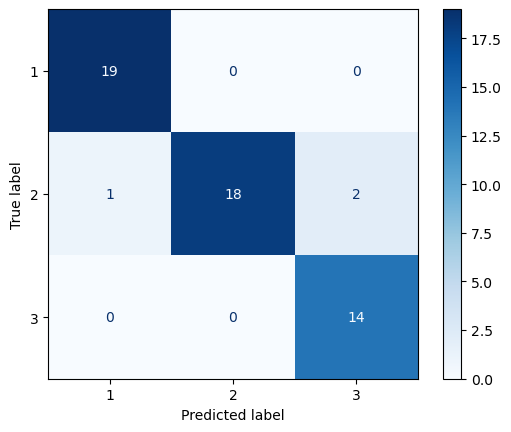

In [63]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap="Blues")

In [64]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9444444444444444

The accuracy score of the KNN model on the test set is approximately 94.44%. This means that the model correctly classified 94.44% of the test samples.

## Steps to improve accuracy
While the KNN-model correctly classified most of the test samples, there are ways to improve the accuracy.
<br>We asked ChatGPT: 'How do we improve the accuracy of the KNN Model?' and it gave a couple steps we can take to do so.
<br>One of these steps is experimenting with different values of `n_neighbors` to see which one is the best. 
<br>ChatGPT suggests using `GridSearchCV` for this, so we imported the package, asked for code and we will try it out in the next section.


In [65]:
# Importing the package
from sklearn.model_selection import GridSearchCV

# Define the range of neighbors to test
param_grid = {'n_neighbors': range(1, 21)}

# Initialize GridSearchCV with the KNN model and the parameter grid
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Find the best parameters and model
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print("Best number of neighbors:", best_n_neighbors)
print("Best cross-validation accuracy:", best_score)

# Train the final model with the optimal n_neighbors
knn_best = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_best.fit(X_train, y_train)

# Evaluate on the test set
y_pred_best = knn_best.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Test set accuracy with optimal n_neighbors:", accuracy_best)

Best number of neighbors: 11
Best cross-validation accuracy: 0.976
Test set accuracy with optimal n_neighbors: 0.9629629629629629


Now to display it in a confusion matrix:

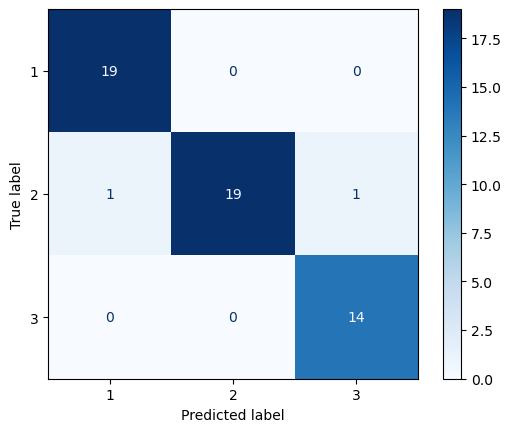

In [66]:
# Generate a confusion matrix using the predictions from the best model
cm_best = confusion_matrix(y_test, y_pred_best, labels=knn_best.classes_)

# Display the confusion matrix with blue color scheme
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=knn_best.classes_)
disp.plot(cmap="Blues")
plt.show()

In [67]:
accuracy = accuracy_score(y_test, y_pred_best)
accuracy

0.9629629629629629

This time, the accuracy score of the KNN model on the test set is approximately 96.3%. 
<br>This means that the model correctly classified 96.3% of the test samples, which is more than the 94.44% from the first run.
<br>Using `GridSearchCV` to find the optimal number of neighbors has therefore increased the accuracy by around 2%.

Other suggestions ChatGPT gave are the following:

#### 1. Hyperparameter Tuning:
- Try adjusting the `weights` parameter (e.g., `uniform` vs. `distance`), which determines whether each neighbor's contribution to classification is weighted by its distance to the point.

#### 2. Feature Selection or Engineering:
- Use feature selection techniques to identify the most informative features for classification. Removing irrelevant or redundant features can help the model focus on more meaningful data.
- Consider creating new features by combining existing ones, if there are meaningful relationships (e.g., ratios or interactions between chemical properties).

#### 3. Data Scaling Variants:
- Although you are already normalizing the data, you can try different scaling methods, such as **MinMaxScaler** or **RobustScaler**, to see if they improve the model's sensitivity to certain features.

#### 4. Dimensionality Reduction:
- Techniques like **Principal Component Analysis (PCA)** can help reduce the dimensionality of the data, which may make it easier for KNN to find meaningful neighbors, especially if there is noise in high-dimensional space.

#### 5. Increase Training Data:
- If possible, adding more data samples can improve model accuracy by providing more examples of each class, helping KNN make better decisions.

#### 6. Try a Different Model:
- KNN might not always be the best model for every dataset. If improvements are limited, you might try other classifiers such as **Random Forests**, **SVM**, or **Logistic Regression**, which could be more effective for this dataset.

Each of these approaches can be tested individually or combined to see which improves accuracy the most.


We will not apply these steps in this KNN-workbook, but we will be exploring other models and using them to see if they perform better or worse than KNN.

# End of the KNN-notebook.